# Data cleaning and preprocessing




In [13]:
!pip show xgboost



Name: xgboost
Version: 2.1.2
Summary: XGBoost Python Package
Home-page: 
Author: 
Author-email: Hyunsu Cho <chohyu01@cs.washington.edu>, Jiaming Yuan <jm.yuan@outlook.com>
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, nvidia-nccl-cu12, scipy
Required-by: 


In [17]:
# Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
!pip install xgboost
!pip install shap

import shap
import matplotlib.pyplot as plt


In [18]:
# Data loading
BookData = pd.read_csv("ForecastDataBookings.csv")

In [19]:
# Split dataset

# Splitting training+Validationset and testset (70/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(BookData.drop(columns=['Status']),  BookData['Status'],  test_size=0.3,  random_state=42)

# Splitting trainingset and validationset (70: 80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val,  y_train_val,  test_size=0.2,  random_state=42)

In [ ]:
# Missing values

# Impute missing values with mode for the features Children and Country
# Mode of the trainset
ModeChildren = X_train['Children'].mode()[0]
ModeCountry = X_train['Country'].mode()[0]

# Feature: Children
X_train['Children'] = X_train['Children'].fillna(X_train['Children'].mode()[0])
X_val['Children'] = X_val['Children'].fillna(X_train['Children'].mode()[0])
X_test['Children'] = X_test['Children'].fillna(X_train['Children'].mode()[0])

# Feature: Country
X_train['Country'] = X_train['Country'].fillna(X_train['Country'].mode()[0])
X_val['Country'] = X_val['Country'].fillna(X_train['Country'].mode()[0])
X_test['Country'] = X_test['Country'].fillna(X_train['Country'].mode()[0])


# Drop features because many NULL values, and both have over 300 classes. Computational expensive
#Feature: Agent and Company
X_train = X_train.drop(['Agent', 'Company'], axis=1)
X_val = X_val.drop(['Agent', 'Company'], axis=1)
X_test = X_test.drop(['Agent', 'Company'], axis=1)


In [21]:
# One-hot-encoding for categorical features

# Transform feature IsRepeatedGuest to a category
X_train['IsRepeatedGuest'] = X_train['IsRepeatedGuest'].astype('category')
X_val['IsRepeatedGuest'] = X_val['IsRepeatedGuest'].astype('category')
X_test['IsRepeatedGuest'] = X_test['IsRepeatedGuest'].astype('category')

# Top 25 + Other for feature Country (Top 25 from trainset)
TopN = 25
TopCountries = X_train['Country'].value_counts().nlargest(TopN).index
X_train['Country'] = X_train['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_val['Country'] = X_val['Country'].apply(lambda x: x if x in TopCountries else 'Other')
X_test['Country'] = X_test['Country'].apply(lambda x: x if x in TopCountries else 'Other')

# All categorical features
CategoricalFeatures = ['Country',
                       'Hotel',
                       'Meal',
                       'MarketSegment',
                       'DistributionChannel',
                       'ReservedRoomType',
                       'AssignedRoomType',
                       'DepositType',
                       'CustomerType',
                       'IsRepeatedGuest']

# One-hot-encoding CategoricalFeatures
X_train = pd.get_dummies(X_train, columns=CategoricalFeatures, drop_first=False)
X_val = pd.get_dummies(X_val, columns=CategoricalFeatures, drop_first=False)
X_test = pd.get_dummies(X_test, columns=CategoricalFeatures, drop_first=False)

# Consistency between train, validation and test sets
X_train, X_val = X_train.align(X_val, join='left', axis=1)
X_train, X_test = X_train.align(X_test, join='left', axis=1)



In [22]:
# Processing date features

# ArrivalDateMonth from Object to Integer
MonthChange = {
                'January': 1,
                'February': 2,
                'March': 3,
                'April': 4,
                'May': 5,
                'June': 6,
                'July': 7,
                'August': 8,
                'September': 9,
                'October': 10,
                'November': 11,
                'December': 12
            }

X_train['ArrivalDateMonth'] = X_train['ArrivalDateMonth'].map(MonthChange)
X_val['ArrivalDateMonth'] = X_val['ArrivalDateMonth'].map(MonthChange)
X_test['ArrivalDateMonth'] = X_test['ArrivalDateMonth'].map(MonthChange)

# Sinus- and cosinustransformation (Arrival month)
X_train['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateMonth'] / 12)
X_train['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateMonth'] / 12)

X_val['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateMonth'] / 12)
X_val['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateMonth'] / 12)

X_test['ArrivalDateMonth_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateMonth'] / 12)
X_test['ArrivalDateMonth_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateMonth'] / 12)

# Sinus- and cosinustransformation (Arrival week). Dataset has 53 weeks in a year.
X_train['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)
X_train['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_train['ArrivalDateWeekNumber'] / 53)

X_val['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)
X_val['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_val['ArrivalDateWeekNumber'] / 53)

X_test['ArrivalDateWeekNumber_Sin'] = np.sin(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)
X_test['ArrivalDateWeekNumber_Cos'] = np.cos(2 * np.pi * X_test['ArrivalDateWeekNumber'] / 53)

# Sinus- and cosinustransformation (Arrival day of month)

# Function: Check if the year is a leap year
def IsLeapYear(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

# Function: Assign number of days to the months, including the leap year difference for February
def NumberOfDaysInMonth(month, year):
    if month == 2:
        return 29 if IsLeapYear(year) else 28
    return 31 if month in [1, 3, 5, 7, 8, 10, 12] else 30

X_train['ArrivalDateDay_Sin'] = X_train.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_train['ArrivalDateDay_Cos'] = X_train.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_val['ArrivalDateDay_Sin'] = X_val.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_val['ArrivalDateDay_Cos'] = X_val.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

X_test['ArrivalDateDay_Sin'] = X_test.apply(lambda row: np.sin(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)
X_test['ArrivalDateDay_Cos'] = X_test.apply(lambda row: np.cos(2 * np.pi * row['ArrivalDateDayOfMonth'] / NumberOfDaysInMonth(row['ArrivalDateMonth'], row['ArrivalDateYear'])), axis=1)

In [23]:
# Drop features that are correlated to other features in the dataset

features_to_drop = ['ArrivalDateMonth', 'ArrivalDateWeekNumber', 'ArrivalDateDayOfMonth', 'StaysInNights', 'ArrivalDate', 'CheckoutDate', 'ReservationStatusDate']

X_train = X_train.drop(features_to_drop, axis=1)
X_val = X_val.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)

# Model Random Forest

In [50]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, learning_curve, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np


## Model without SMOTE

In [51]:
# Random forest on train set
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [53]:
# Defining the hyperparameter space
param_dist = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 20],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.8, 0.9]
}



In [54]:
# Defining StratifiedKFold for consistency between folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search with 5 folds (defined in stratified_kfold) and 10 iterations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_weighted',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"Best parameters found: {random_search.best_params_}")



Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced', 'bootstrap': True}


In [55]:
# Using best model for prediction
best_rf = random_search.best_estimator_

y_train_pred = best_rf.predict(X_train)
y_val_pred = best_rf.predict(X_val)
y_test_pred = best_rf.predict(X_test)


Train Set Results
                   precision    recall  f1-score   support

        Check-Out       0.95      0.80      0.87     42189
Early Cancelation       0.79      0.85      0.82     19191
 Late Cancelation       0.40      0.77      0.52      4786
          No-Show       0.43      0.92      0.58       692

         accuracy                           0.81     66858
        macro avg       0.64      0.83      0.70     66858
     weighted avg       0.86      0.81      0.83     66858



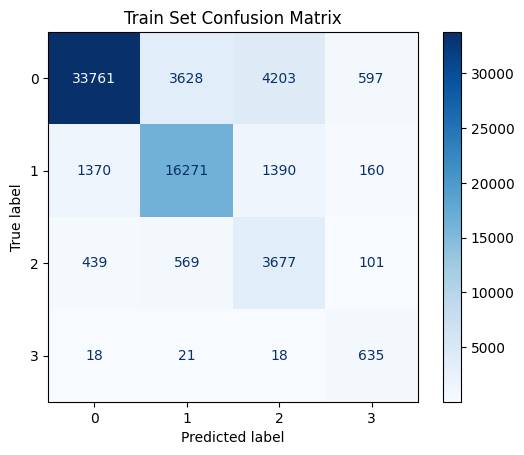

Validation Set Results
                   precision    recall  f1-score   support

        Check-Out       0.92      0.78      0.84     10499
Early Cancelation       0.78      0.83      0.80      4817
 Late Cancelation       0.31      0.59      0.41      1233
          No-Show       0.16      0.29      0.21       166

         accuracy                           0.78     16715
        macro avg       0.54      0.62      0.57     16715
     weighted avg       0.82      0.78      0.79     16715



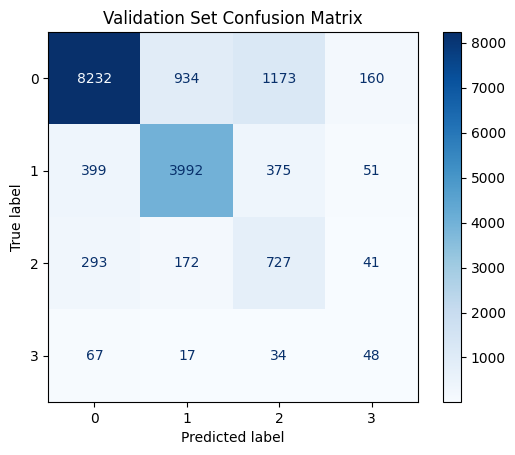

Test Set Results
                   precision    recall  f1-score   support

        Check-Out       0.92      0.78      0.85     22478
Early Cancelation       0.78      0.82      0.80     10433
 Late Cancelation       0.31      0.60      0.41      2557
          No-Show       0.17      0.32      0.22       349

         accuracy                           0.78     35817
        macro avg       0.54      0.63      0.57     35817
     weighted avg       0.83      0.78      0.80     35817



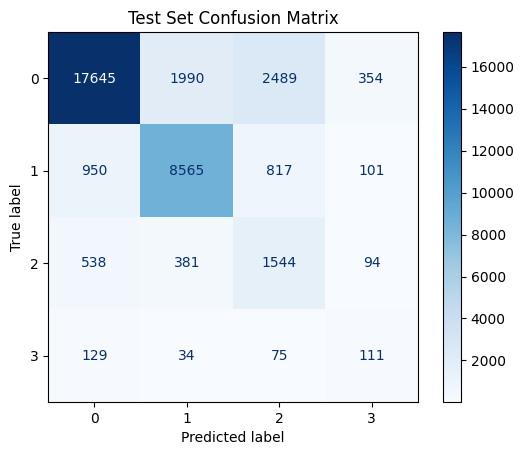

In [56]:
# Confusion matrix for train, validation and test results

# Train
print("Train Set Results")
print(classification_report(y_train, y_train_pred))
train_cm = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation
print("Validation Set Results")
print(classification_report(y_val, y_val_pred))
val_cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test
print("Test Set Results")
print(classification_report(y_test, y_test_pred))
test_cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()






## Model with SMOTE

In [71]:
# Smote for class imbalances

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_smote))


Class distribution before SMOTE: Counter({'Check-Out': 42189, 'Early Cancelation': 19191, 'Late Cancelation': 4786, 'No-Show': 692})
Class distribution after SMOTE: Counter({'Check-Out': 42189, 'Late Cancelation': 42189, 'Early Cancelation': 42189, 'No-Show': 42189})


In [72]:
# Random forest on train set with smote
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)



RandomForestClassifier(random_state=42)

In [73]:
# Defining the hyperparameter space
param_dist = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 20],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.8, 0.9]
}



In [74]:
# Defining StratifiedKFold for consistency between folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search with 5 folds (defined in stratified_kfold) and 10 iterations
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_weighted',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_smote, y_train_smote)

print(f"Best parameters found: {random_search.best_params_}")



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced', 'bootstrap': True}


In [75]:
# Using best model for prediction
best_rf = random_search.best_estimator_

y_train_pred = best_rf.predict(X_train_smote)
y_val_pred = best_rf.predict(X_val)
y_test_pred = best_rf.predict(X_test)


Train Set Results
                   precision    recall  f1-score   support

        Check-Out       0.85      0.89      0.87     42189
Early Cancelation       0.87      0.80      0.84     42189
 Late Cancelation       0.86      0.81      0.83     42189
          No-Show       0.89      0.97      0.93     42189

         accuracy                           0.87    168756
        macro avg       0.87      0.87      0.87    168756
     weighted avg       0.87      0.87      0.87    168756



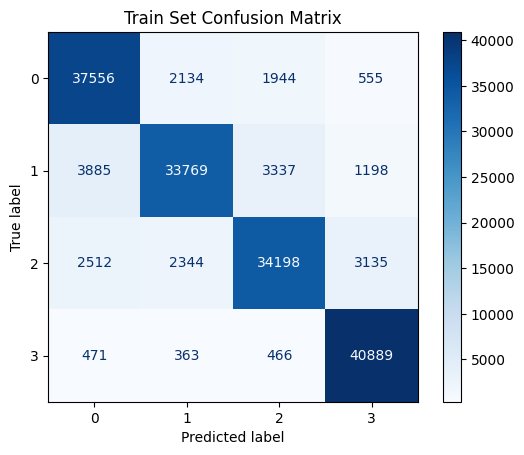

Validation Set Results
                   precision    recall  f1-score   support

        Check-Out       0.86      0.88      0.87     10499
Early Cancelation       0.84      0.78      0.81      4817
 Late Cancelation       0.43      0.46      0.44      1233
          No-Show       0.17      0.27      0.20       166

         accuracy                           0.81     16715
        macro avg       0.58      0.59      0.58     16715
     weighted avg       0.82      0.81      0.82     16715



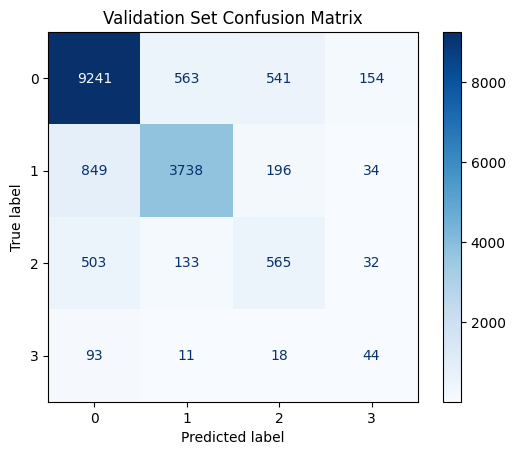

Test Set Results
                   precision    recall  f1-score   support

        Check-Out       0.87      0.88      0.87     22478
Early Cancelation       0.83      0.76      0.80     10433
 Late Cancelation       0.42      0.47      0.45      2557
          No-Show       0.16      0.25      0.20       349

         accuracy                           0.81     35817
        macro avg       0.57      0.59      0.58     35817
     weighted avg       0.82      0.81      0.81     35817



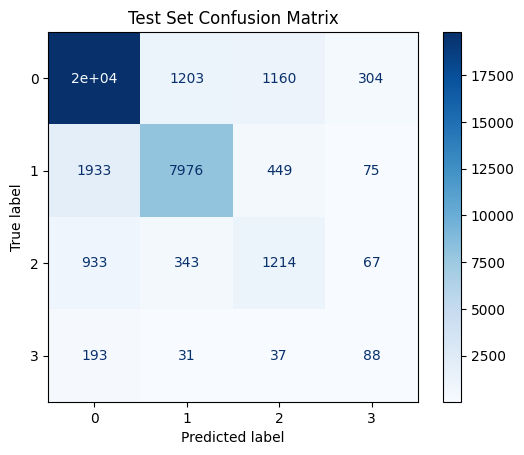

In [76]:
# Confusion matrix for train, validation and test results

# Train
print("Train Set Results")
print(classification_report(y_train_smote, y_train_pred))
train_cm = confusion_matrix(y_train_smote, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation
print("Validation Set Results")
print(classification_report(y_val, y_val_pred))
val_cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test
print("Test Set Results")
print(classification_report(y_test, y_test_pred))
test_cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()






## Feature importance analysis

In [57]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Permutation importance calculation on the validation set
perm_importance = permutation_importance(best_rf, X_val, y_val, n_repeats=10, random_state=42, scoring='f1_macro')



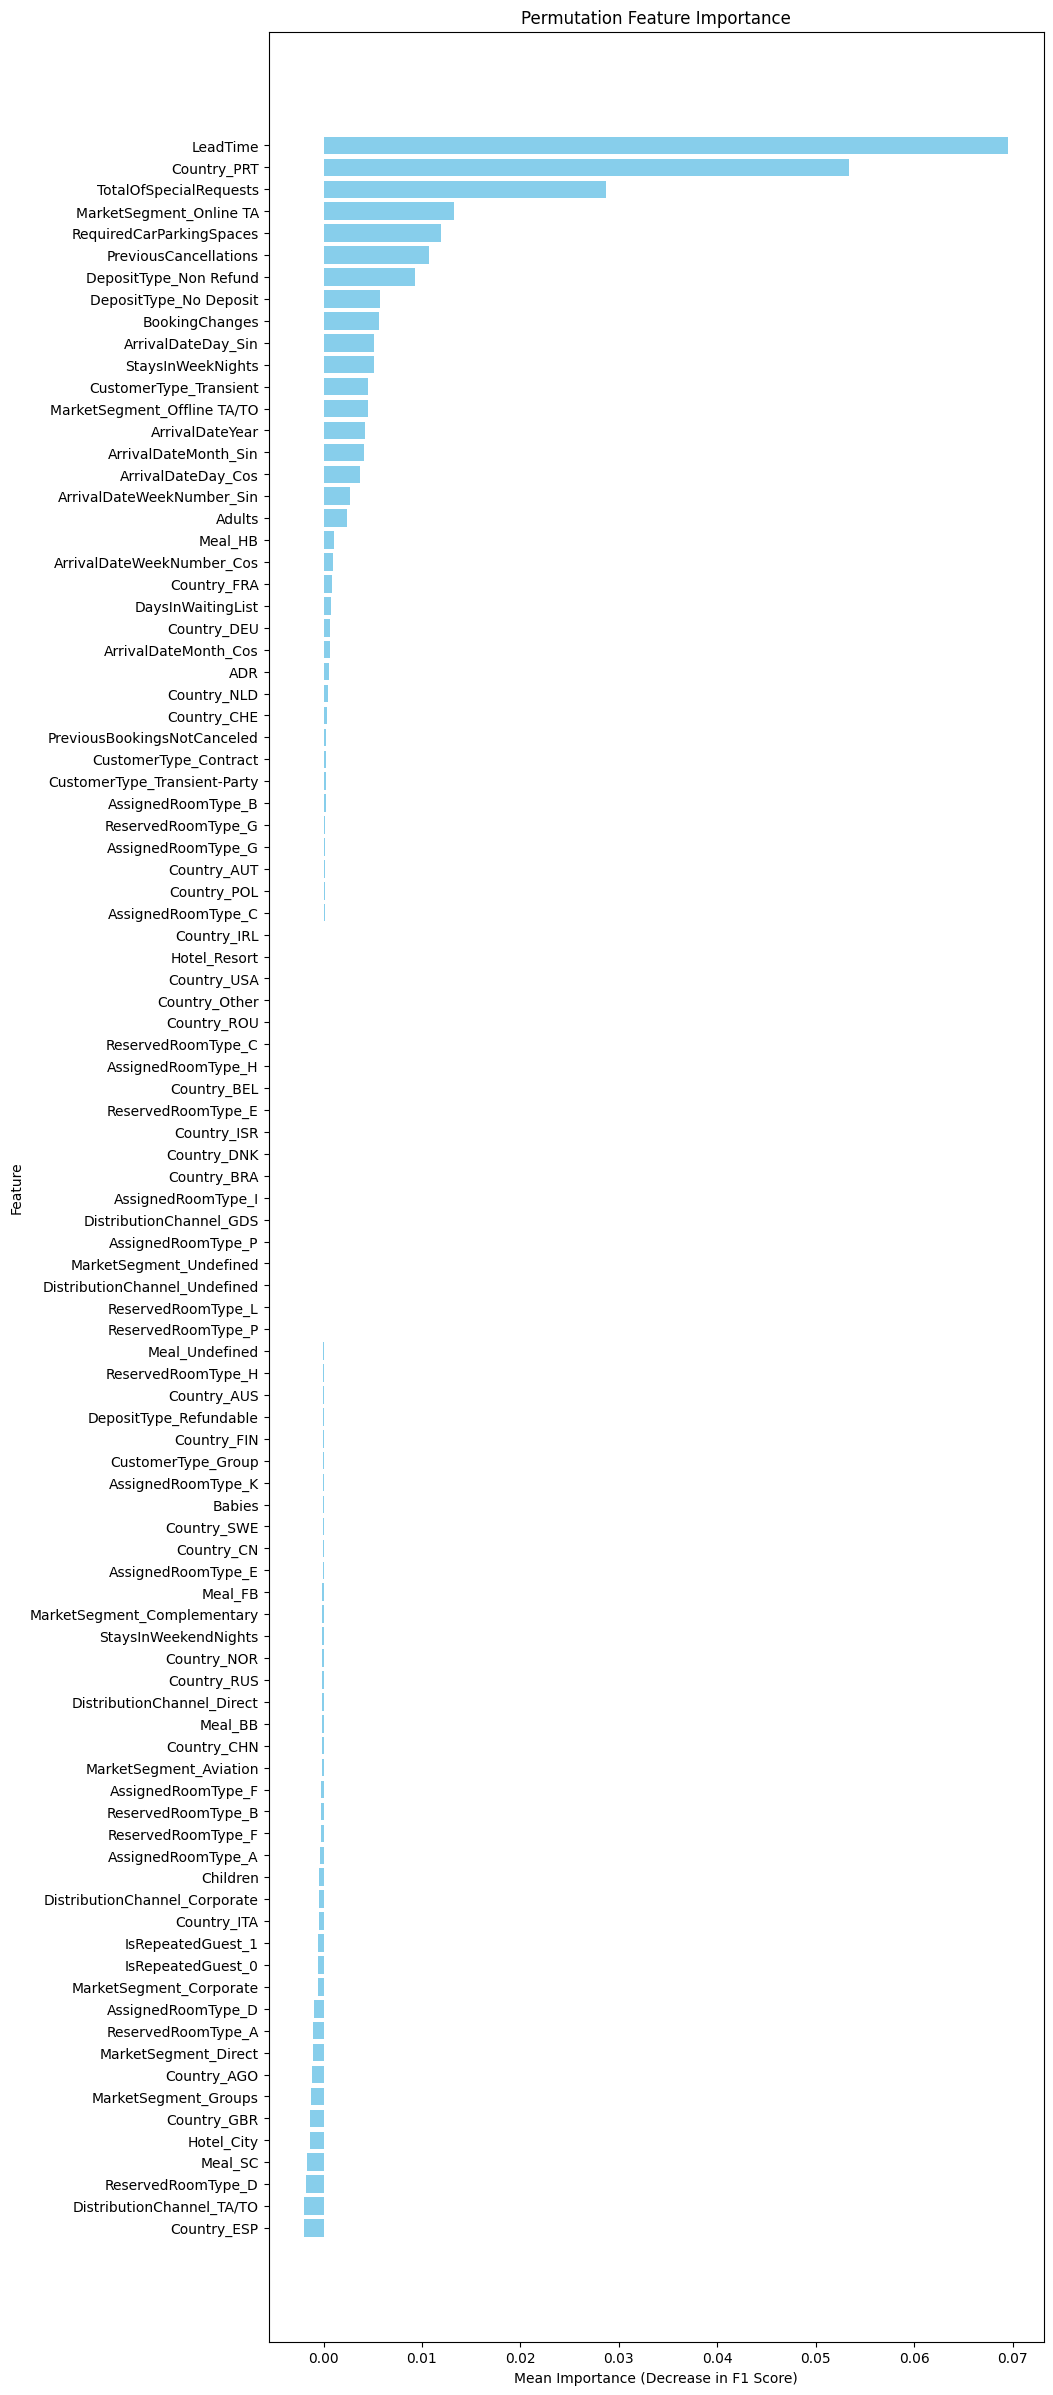

                      Feature  Mean Importance  Importance StdDev
95                   LeadTime         0.069563           0.003745
94                Country_PRT         0.053372           0.002984
93     TotalOfSpecialRequests         0.028682           0.002835
92    MarketSegment_Online TA         0.013229           0.002963
91   RequiredCarParkingSpaces         0.011893           0.001274
..                        ...              ...                ...
4                  Hotel_City        -0.001365           0.002214
3                     Meal_SC        -0.001664           0.000612
2          ReservedRoomType_D        -0.001822           0.000287
1   DistributionChannel_TA/TO        -0.001950           0.001754
0                 Country_ESP        -0.002006           0.000452

[96 rows x 3 columns]


In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Sorting the results
sorted_idx = perm_importance.importances_mean.argsort()

# Getting the feature names for plotting
feature_names = X_train.columns

# Visualisation of the permutation importance analysis
plt.figure(figsize=(10, 30))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx], color='skyblue')
plt.xlabel("Mean Importance (Decrease in F1 Score)")
plt.ylabel("Feature")
plt.title("Permutation Feature Importance")
plt.show()

# Most important features
importance_df = pd.DataFrame({
    'Feature': feature_names[sorted_idx],
    'Mean Importance': perm_importance.importances_mean[sorted_idx],
    'Importance StdDev': perm_importance.importances_std[sorted_idx]
}).sort_values(by='Mean Importance', ascending=False)

print(importance_df)


In [62]:
# Number of features
top_n = 15

# Top n most important features
top_features = importance_df.head(top_n)

# Bottom n features
bottom_features = importance_df.tail(top_n)

# Reset
top_features.reset_index(drop=True, inplace=True)
bottom_features.reset_index(drop=True, inplace=True)

# Tables
print("Top Features:")
print(top_features)

print("\nBottom Features:")
print(bottom_features)


Top Features:
                        Feature  Mean Importance  Importance StdDev
0                      LeadTime         0.069563           0.003745
1                   Country_PRT         0.053372           0.002984
2        TotalOfSpecialRequests         0.028682           0.002835
3       MarketSegment_Online TA         0.013229           0.002963
4      RequiredCarParkingSpaces         0.011893           0.001274
5         PreviousCancellations         0.010745           0.001593
6        DepositType_Non Refund         0.009293           0.002531
7        DepositType_No Deposit         0.005707           0.002277
8                BookingChanges         0.005592           0.001683
9            ArrivalDateDay_Sin         0.005147           0.002309
10            StaysInWeekNights         0.005087           0.001554
11       CustomerType_Transient         0.004546           0.001711
12  MarketSegment_Offline TA/TO         0.004518           0.001477
13              ArrivalDateYear   

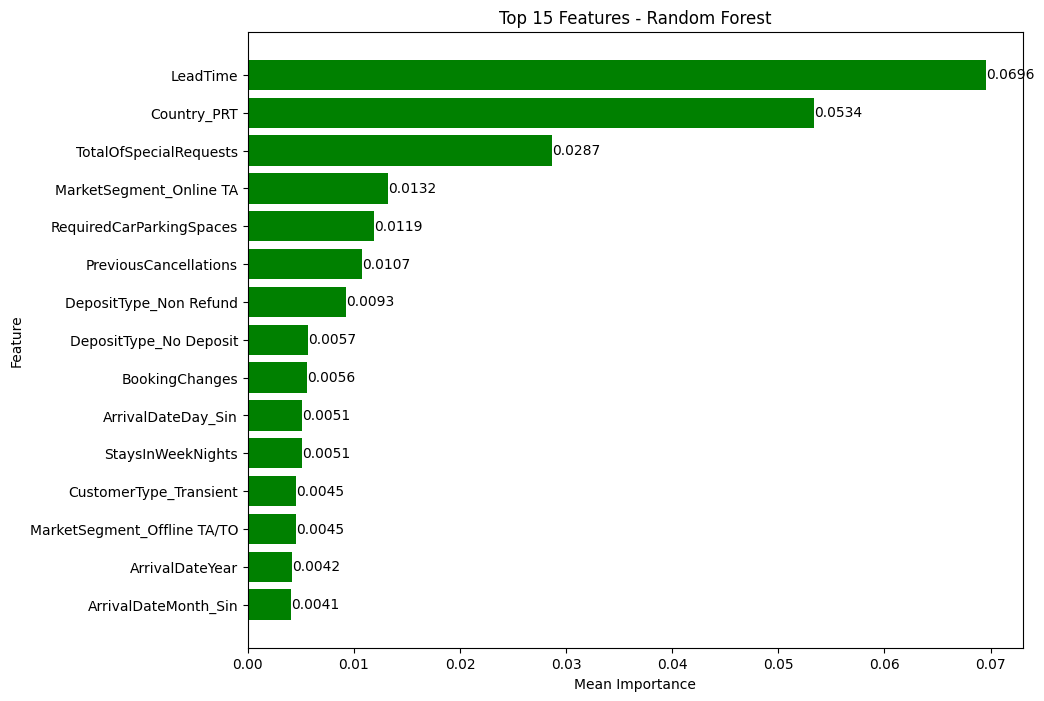

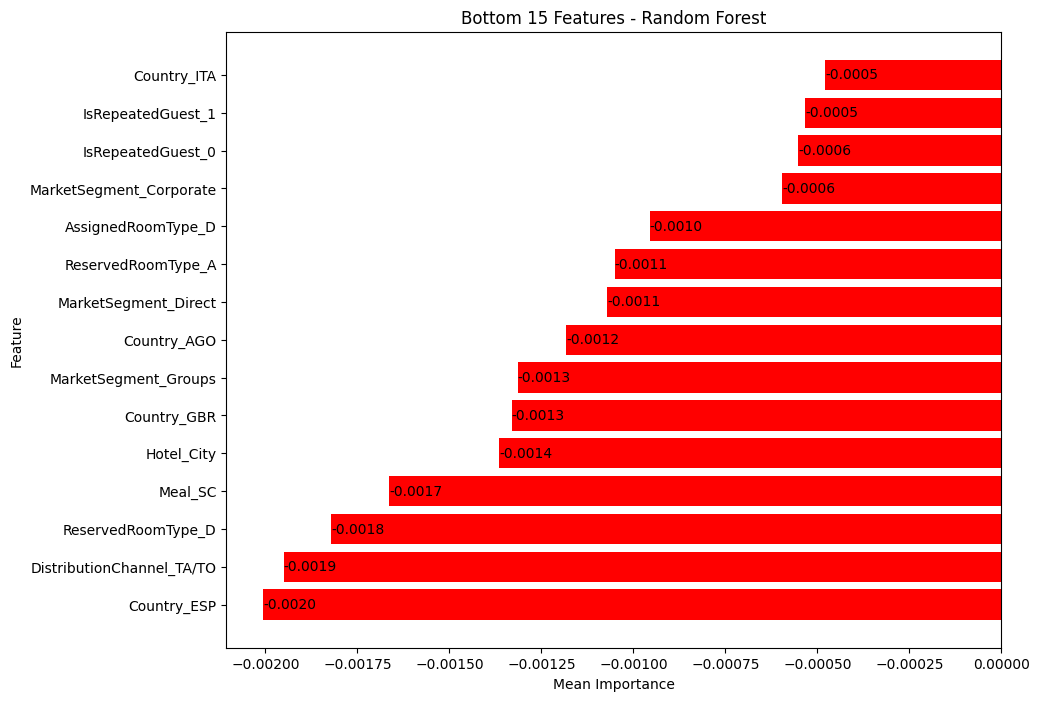

In [81]:
# Top features
top_features_sorted = top_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(top_features_sorted['Feature'], top_features_sorted['Mean Importance'], color='green')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Top 15 Features - Random Forest")

for bar, value in zip(bars, top_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()

# Bottom features
bottom_features_sorted = bottom_features.sort_values(by='Mean Importance', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(bottom_features_sorted['Feature'], bottom_features_sorted['Mean Importance'], color='red')
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.title("Bottom 15 Features - Random Forest")

for bar, value in zip(bars, bottom_features_sorted['Mean Importance']):
    plt.text(value, bar.get_y() + bar.get_height()/2, f'{value:.4f}', va='center')

plt.show()


## New model with selected features

In [82]:

# Extract the mean importance scores
importances_mean = perm_importance.importances_mean

# Setting a threshold for most important features
importance_threshold = 0.001

# Select the indices of features whose importance is above the threshold
important_features_idx = sorted_idx[importances_mean > importance_threshold]

# Retrieve the names of the selected features
selected_feature_names = feature_names[important_features_idx]

# Print the number of selected features
print(f"Number of selected features: {len(selected_feature_names)}")


Number of selected features: 20


In [83]:
# Filtering the original datasets to select the top features for new dataset
X_train_smote_selected = X_train_smote[selected_feature_names]
X_val_selected = X_val[selected_feature_names]
X_test_selected = X_test[selected_feature_names]


In [84]:
# Training the new model with the selected features
best_rf_selected = RandomForestClassifier(random_state=42)

In [86]:
# Defining the hyperparameter space

param_dist = {
    'n_estimators': [20, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 20],
    'bootstrap': [True],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample'],
    'max_samples': [0.8, 0.9]
}






# Defining StratifiedKFold for consistency between folds
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized search with 5 folds and 10 iterations
best_random_search = RandomizedSearchCV(
    estimator=best_rf_selected,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1_weighted',
    cv=stratified_kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


best_random_search.fit(X_train_smote_selected, y_train_smote)

print(f"Best parameters found: {random_search.best_params_}")



Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.8, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced', 'bootstrap': True}


In [90]:
# New predictions on train, validation and testset
best_rf_selected = best_random_search.best_estimator_

# predict the train, validation and testset
y_train_pred = best_rf_selected.predict(X_train_smote_selected)
y_val_pred = best_rf_selected.predict(X_val_selected)
y_test_pred = best_rf_selected.predict(X_test_selected)



Train Set Results
                   precision    recall  f1-score   support

        Check-Out       0.80      0.79      0.80     42189
Early Cancelation       0.76      0.79      0.78     42189
 Late Cancelation       0.75      0.66      0.70     42189
          No-Show       0.79      0.86      0.82     42189

         accuracy                           0.78    168756
        macro avg       0.78      0.78      0.78    168756
     weighted avg       0.78      0.78      0.78    168756



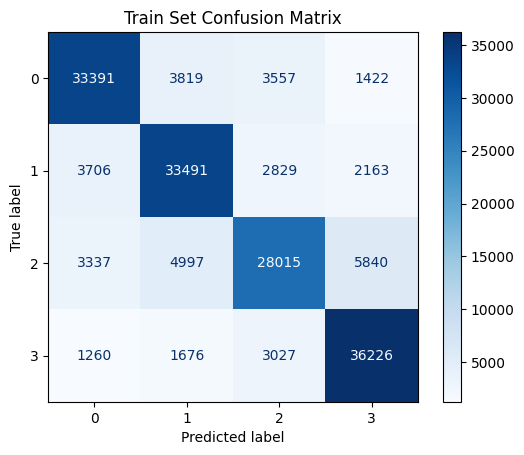

Validation Set Results
                   precision    recall  f1-score   support

        Check-Out       0.87      0.78      0.82     10499
Early Cancelation       0.75      0.78      0.76      4817
 Late Cancelation       0.31      0.46      0.37      1233
          No-Show       0.08      0.26      0.12       166

         accuracy                           0.75     16715
        macro avg       0.50      0.57      0.52     16715
     weighted avg       0.79      0.75      0.77     16715



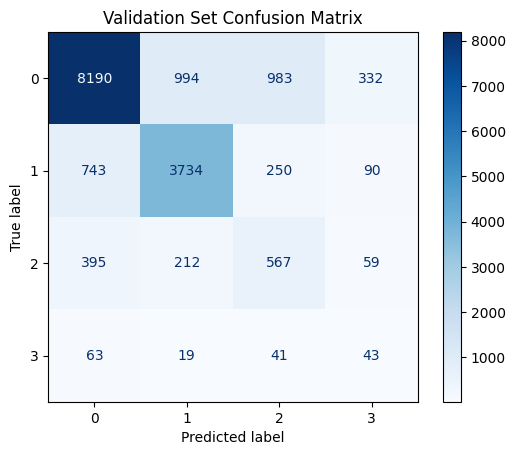

Test Set Results
                   precision    recall  f1-score   support

        Check-Out       0.87      0.79      0.83     22478
Early Cancelation       0.76      0.77      0.77     10433
 Late Cancelation       0.31      0.46      0.37      2557
          No-Show       0.08      0.29      0.13       349

         accuracy                           0.75     35817
        macro avg       0.51      0.58      0.52     35817
     weighted avg       0.79      0.75      0.77     35817



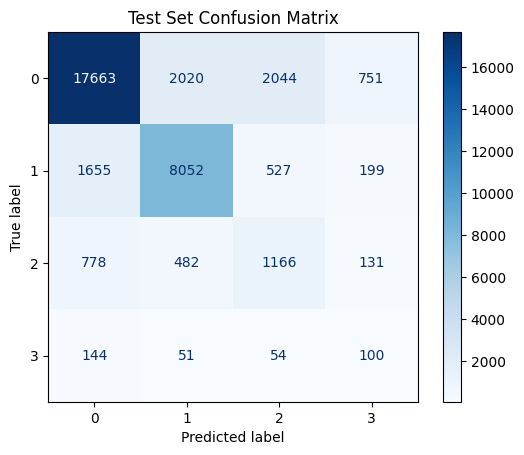

In [89]:
# Confusion matrix train, validation and test results

from sklearn.metrics import classification_report, confusion_matrix

# Train
print("Train Set Results")
print(classification_report(y_train_smote, y_train_pred))
train_cm = confusion_matrix(y_train_smote, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Train Set Confusion Matrix")
plt.show()

# Validation
print("Validation Set Results")
print(classification_report(y_val, y_val_pred))
val_cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=val_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Validation Set Confusion Matrix")
plt.show()

# Test
print("Test Set Results")
print(classification_report(y_test, y_test_pred))
test_cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm)
disp.plot(cmap=plt.cm.Blues, colorbar=True)
plt.title("Test Set Confusion Matrix")
plt.show()
